# AI Training with all models 


In [1]:
#Imports:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import autokeras as ak
import xgboost as xgb
import catboost as cat
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from tensorflow.keras.models import load_model
from sklearn.utils import resample,shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network


In [2]:
# Methods to test the predictions

def count_points(pred, gold):
    df = pd.merge(pred, gold, on=['userID', 'itemID'], suffixes=('_pred', '_gold'))
    df['points'] = df.apply(_compute_points_for_row, axis=1)
    return df['points'].sum()

def _compute_points_for_row(row):
    y_pred, y_gold = row.prediction_pred, row.prediction_gold
    if y_pred == y_gold:
        # one point if "no order" (0) is predicted correctly; three points if order week is predicted correctly
        return 1 if y_pred == 0 else 3
    # one point if order is predicted correctly (but not the correct week), otherwise zero points
    return 1 if (y_pred > 0 and y_gold > 0) else 0

def preprocessData(df):
    labels = df["label"] # generating a label dataset
    data = df.drop(['label'], axis = 1) #dropping label
    data = df.drop(['order'], axis = 1) #dropping order
    data = df.drop(['date'], axis = 1) #dropping date
    
    enc = OneHotEncoder(handle_unknown='ignore') #onehotencoder
    cols = ["feature_1", "feature_2", "feature_4"] #columns to onehot encode
    enc.fit(data[cols])
    encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray()) #encoding
    data = data[["userID", "itemID", "brand", "feature_3", "feature_5" 
                 ,]].join(encoder_df) #merging
                 #"date_of_month", "total_purchase_times","purchased_frequency","category", "weekday",]].join(encoder_df) #merging
    
    lb = preprocessing.LabelBinarizer()
    #lenc = enc.fit(np_labels)
    lb = lb.fit(labels.to_numpy())
    labels_enc = lb.transform(labels.to_numpy())
    
    return labels_enc, data, lb, enc

In [3]:
#train_dec = pd.read_csv("train_bef_dec.csv")
train_dec = pd.read_csv("orders_before_jan_labeled.csv", sep = ",")
print(len(train_dec))
df_items = pd.read_csv("items.csv", sep = "|") #items

train_dec = pd.merge(train_dec, df_items, on="itemID") #merging the dataset on itemID 

print(len(train_dec))

y_train, x_train, binarizer, enc = preprocessData(train_dec)

x_train.head()


905881
905881


,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
0,15215,19979,724,503,17,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,39567,19979,724,503,17,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12385,19979,724,503,17,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,27356,19979,724,503,17,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26707,19979,724,503,17,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
test_dec = pd.read_csv("test_dec.csv")
test_dec = test_dec.sort_values(by=["userID"])
print(len(test_dec))
y_test, x_test, binarizer = preprocessData(train_dec)

x_train.head()

113478


ValueError: too many values to unpack (expected 3)

In [4]:
pred_dec = pd.read_csv("prediction_jan.csv", sep = ",")
print(len(pred_dec))
pred_dec.head()

25663


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,category,weekday,date_of_month,total_purchase_times,purchased_frequency,prediction
0,2021/1/12,0,20664,2,430,4,0,335,0,70,1330,1,12,38,0.13,NaN
1,2021/1/12,17516,3148,2,430,4,0,335,0,70,1330,1,12,38,0.13,NaN
2,2021/1/29,0,28231,6,1496,10,0,348,0,95,3898,4,29,55,22.19,NaN
3,2021/1/11,0,28231,2,618,4,0,321,0,144,3898,0,11,36,5.13,NaN
4,2021/1/5,0,28231,1,194,10,0,503,0,17,3898,1,5,16,1.16,NaN


In [5]:
name = 'submission_jan'

df_submission = pd.read_csv( name+".csv", sep = "|")

result_pred = pd.merge(df_submission, df_items, on="itemID")

result_pred = result_pred.drop(['categories'], axis = 1)
data = result_pred.drop(['prediction'], axis = 1)
cols = ["feature_1", "feature_2", "feature_4"]

encoder_df = pd.DataFrame(enc.transform(data[cols]).toarray())
submission = data[["userID","itemID", "brand", "feature_3", "feature_5"]].join(encoder_df)

submission

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
0,0,20664,408,284,66,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23363,20664,408,284,66,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,28231,193,468,108,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,13,2690,406,491,66,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,15,1299,1056,474,108,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9935,46049,17984,449,207,45,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9936,46069,29992,280,484,44,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9937,46117,8847,143,46,69,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9938,46124,19677,1006,491,154,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
sm = SMOTE(random_state=42)

x_train, y_train=  sm.fit_resample(x_train, y_train)

X_train, X_test, y_train, y_test= train_test_split(x_train, y_train, test_size=0.5, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.3, random_state=42)

print(len(X_train.shape), len(X_test.shape), len(X_val.shape))


C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


2 2 2


In [7]:
X_train_arr = X_train.to_numpy()
X_val_arr = X_val.to_numpy()
X_test_arr = X_test.to_numpy()

y_val_n = binarizer.inverse_transform(y_val)
y_train_n = binarizer.inverse_transform(y_train)
y_test_n = binarizer.inverse_transform(y_test)

In [8]:
len(X_train_arr)

1544495

## Models

In [10]:
# Autokeras
model = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.ClassificationHead()],
    max_trials=3,
    overwrite = True
)

model.fit(
    x=X_train_arr, y=y_train, epochs=100, batch_size=128, validation_data= [X_val_arr, y_val]
)


res_train_ak = model.predict(X_train_arr)
res_test_ak = model.predict(X_test_arr)
res_val_ak = model.predict(X_val_arr)


model = model.export_model()


try:
    model.save("model_autokeras_jan_class", save_format="tf")
except Exception:
    model.save("model_autokeras_jan_class.h5")

Trial 3 Complete [00h 14m 31s]
val_loss: 1.3601391315460205

Best val_loss So Far: 1.3108464479446411
Total elapsed time: 00h 47m 59s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
12067/12067 [==============================] - 29s 2ms/step - loss: 11.1613 - accuracy: 0.3344 - val_loss: 1.3802 - val_accuracy: 0.3624
Epoch 2/100
12067/12067 [==============================] - 29s 2ms/step - loss: 1.3684 - accuracy: 0.3688 - val_loss: 1.3498 - val_accuracy: 0.3677
Epoch 3/100
12067/12067 [==============================] - 28s 2ms/step - loss: 1.3532 - accuracy: 0.3751 - val_loss: 1.3459 - val_accuracy: 0.3714
Epoch 4/100
12067/12067 [==============================] - 28s 2ms/step - loss: 1.3486 - accuracy: 0.3767 - val_loss: 1.3489 - val_accuracy: 0.3679
Epoch 5/100
12067/12067 [==============================] - 28s 2ms/step - loss: 1.3456 - accuracy: 0.3775 - val_loss: 1.3432 - val_accuracy: 0.3749
Epoch 6/100
12067/12067 [==============================] - 29s 2ms/step - loss: 1.3428 

Epoch 55/100
12067/12067 [==============================] - 34s 3ms/step - loss: 1.3053 - accuracy: 0.3868 - val_loss: 1.3036 - val_accuracy: 0.3915
Epoch 56/100
12067/12067 [==============================] - 32s 3ms/step - loss: 1.3043 - accuracy: 0.3868 - val_loss: 1.3102 - val_accuracy: 0.3886
Epoch 57/100
12067/12067 [==============================] - 35s 3ms/step - loss: 1.3066 - accuracy: 0.3867 - val_loss: 1.3044 - val_accuracy: 0.3913
Epoch 58/100
12067/12067 [==============================] - 33s 3ms/step - loss: 1.3052 - accuracy: 0.3867 - val_loss: 1.3092 - val_accuracy: 0.3911
Epoch 59/100
12067/12067 [==============================] - 34s 3ms/step - loss: 1.3052 - accuracy: 0.3869 - val_loss: 1.3050 - val_accuracy: 0.3901
Epoch 60/100
12067/12067 [==============================] - 32s 3ms/step - loss: 1.3044 - accuracy: 0.3869 - val_loss: 1.3040 - val_accuracy: 0.3913
Epoch 61/100
12067/12067 [==============================] - 32s 3ms/step - loss: 1.3073 - accuracy: 0.3861

In [11]:
def baseline(classifier,x_train_dt,x_test_dt,y_train_dt,y_test_dt):
    baseline=classifier
    baseline.fit(x_train_dt,y_train_dt)
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    pred=baseline.predict(x_test_dt)
    print('CV score with default parameters:{}'.format(cross_val_score(classifier,x_train_dt, y_train_dt, cv=stratified_10_fold_cv, scoring='accuracy').mean()))
    print('classification_report on test set with default parameters:\n')
    print(classification_report(y_test_dt,pred))
    # cnf_matrix = confusion_matrix(y_test_dt,pred)    
    #np.set_printoptions(precision=2)
   # plot_confusion_matrix(cnf_matrix,classes=labels,title='confusion matrix:default')
    return baseline


def naivebayes (x_train,x_test,y_train,y_test):
    gnb=GaussianNB()
    gnb.fit(x_train, y_train)
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracy=cross_val_score(gnb,x_train,y_train,cv=cv)
    print('Mean CV score is: {}'.format(accuracy.mean()))
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    grid_search = GridSearchCV( estimator=gnb,param_grid=params_NB, cv=cv,verbose=1, scoring='accuracy') 
    grid_search.fit(x_train, y_train)
    print("The best parameter is:{}".format(grid_search.best_params_))
    print("The best validation score is:{}".format(grid_search.best_score_))
    gnb.set_params(var_smoothing=grid_search.best_params_)
    prediction = gnb.predict(x_test)
    print(classification_report(y_test, prediction))
    cm=confusion_matrix(y_test,prediction)    
    
    return gnb

def decisionTree(x_train,x_test,y_train,y_test):
    
    parameters={
            'criterion':['gini','entropy'],
            'max_depth':[2,3,4,5,6,7,8]
            }
    dtree=DecisionTreeClassifier()
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    grid_search=GridSearchCV(dtree,parameters,scoring='accuracy',cv=stratified_10_fold_cv)
    grid_search.fit(x_train,y_train) 
    print('CV score with best parameters:{}'.format(cross_val_score(grid_search.best_estimator_,x_train, y_train, cv=stratified_10_fold_cv, scoring='accuracy').mean()))
    print('best parameters:{}'.format(grid_search.best_params_))
    pred=grid_search.predict(x_test)
    print('classification_report with best parameters:\n')
    print(classification_report(y_test,pred))
    #confusion matrix
    dt_cnf_matrix = confusion_matrix(y_test,pred)    
    np.set_printoptions(precision=2)    
    
    return grid_search.best_estimator_

def KNN(x_train,x_test,y_train,y_test):
    
    parameters={
           'n_neighbors' : list(range(1,30)),
        'p': [1,2],
        'weights' : ["uniform", "distance"]
            }
    knn_2 = KNeighborsClassifier()
    stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    Grid_search_knn = GridSearchCV(knn_2, parameters, cv=stratified_10_fold_cv)
    best_model = Grid_search_knn.fit(x_test,y_test)
    #Print The value of best Hyperparameters
    cv_score=cross_val_score(Grid_search_knn.best_estimator_,x_train, y_train, cv=stratified_10_fold_cv, scoring='accuracy').mean()
    print("Mean CV score is {} with params {}".format(cv_score, Grid_search_knn.best_params_))
    pred=Grid_search_knn.predict(x_test)
    #print('classification_report on test set with best parameters:\n')
   # print(classification_report(y_test,pred))
  
    np.set_printoptions(precision=2)
   
    return Grid_search_knn.best_estimator_

In [12]:
model_gnb = baseline(GaussianNB(),X_train_arr,X_val_arr,y_train_n,y_val_n)
print('\n----------after hyperparameter tuning----------\n')
#model_gnb = naivebayes(X_train_arr,X_val_arr,y_train_n,y_val_n)

CV score with default parameters:0.24581303326753545
classification_report on test set with default parameters:

              precision    recall  f1-score   support

           0       0.49      0.16      0.24    132342
           1       0.24      0.41      0.30    132867
           2       0.25      0.11      0.15    132193
           3       0.22      0.37      0.28    131889
           4       0.21      0.18      0.19    132636

    accuracy                           0.25    661927
   macro avg       0.28      0.25      0.23    661927
weighted avg       0.28      0.25      0.23    661927


----------after hyperparameter tuning----------



In [13]:
model_dt = baseline(DecisionTreeClassifier(),X_train_arr,X_val_arr,y_train_n,y_val_n)
print('\n----------after hyperparameter tuning----------\n')
#model_dt = decisionTree(X_train_arr,X_val_arr,y_train_n,y_val_n)

CV score with default parameters:0.9070479346393039
classification_report on test set with default parameters:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    132342
           1       0.94      0.94      0.94    132867
           2       0.89      0.91      0.90    132193
           3       0.88      0.88      0.88    131889
           4       0.89      0.88      0.89    132636

    accuracy                           0.91    661927
   macro avg       0.91      0.91      0.91    661927
weighted avg       0.91      0.91      0.91    661927


----------after hyperparameter tuning----------



In [ ]:
#model_knn = baseline(KNeighborsClassifier(),X_train_arr,X_val_arr,y_train_n,y_val_n)
#print('\n----------after hyperparameter tuning----------\n')
#model_knn = KNN(X_train_arr,X_val_arr,y_train_n,y_val_n)

In [14]:
pickle.dump(model_gnb, open("model_gnb_jan", 'wb'))
pickle.dump(model_dt, open("model_dt_jan", 'wb'))
#pickle.dump(model_knn, open("model_knn", 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [22]:
X_test

,userID,itemID,brand,feature_3,feature_5,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
3102449,14061,32267,1473,194,95,0.0,0.0,0.0,0.0,0.0,...,0.564884,0.0,0.0,0.435116,0.435116,0.000000,0.0,0.0,0.564884,0.0
3942860,1988,19975,764,418,119,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0
17557,42161,15971,361,503,9,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
4360181,3986,14595,1356,491,66,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,0.033058,0.0,0.0,0.966942,0.0
443002,26571,32251,366,497,13,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631011,459,1302,1054,472,107,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.994379,0.005621,0.0,0.0,0.000000,0.0
4277542,12801,19805,575,418,120,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
3297202,23621,15194,1492,359,95,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
735984,45782,8827,1445,-1,-1,0.0,0.0,0.0,0.0,1.0,...,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0


In [23]:
print("Calculate")

res_ak = model.predict(X_test_arr)
res_gnb = model_gnb.predict(X_test_arr)
res_dt = model_dt.predict(X_test_arr)

Stacking_set = pd.DataFrame()
Stacking_set["userID"] = X_test["userID"]
Stacking_set["itemID"] = X_test["itemID"]
Stacking_set["brand"] = X_test["brand"]
Stacking_set["res_ak"] = binarizer.inverse_transform(res_ak)
Stacking_set["res_gnb"] = res_gnb
Stacking_set["res_dt"] = res_dt
Stacking_set["label"] = binarizer.inverse_transform(y_test)

y_test

Calculate


array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [30]:
Stacking_set

,userID,itemID,brand,res_ak,res_gnb,res_dt,label
3102449,14061,32267,1473,1,4,3,3
3942860,1988,19975,764,1,3,4,4
17557,42161,15971,361,0,1,0,0
4360181,3986,14595,1356,1,4,4,4
443002,26571,32251,366,0,0,0,0
...,...,...,...,...,...,...,...
3631011,459,1302,1054,1,1,4,4
4277542,12801,19805,575,1,1,4,4
3297202,23621,15194,1492,1,4,3,3
735984,45782,8827,1445,0,0,0,0


In [31]:
stacking_y = binarizer.transform(Stacking_set["label"])
Stacking_x = Stacking_set.copy()
Stacking_x = Stacking_x.drop(["label"], axis = 1)

X_train, X_val, y_train, y_val= train_test_split(Stacking_x, stacking_y, test_size=0.3, random_state=42)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()


In [32]:
model_final = ak.AutoModel(
    inputs=[ak.StructuredDataInput()],
    outputs=[ak.ClassificationHead()],
    max_trials=1,
    overwrite = True
)

model_final.fit(
    x=X_train, y=y_train, epochs=50, batch_size=128, validation_data= [X_val, y_val]
)


Trial 1 Complete [00h 09m 03s]
val_loss: 0.38114893436431885

Best val_loss So Far: 0.38114893436431885
Total elapsed time: 00h 09m 03s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
12067/12067 [==============================] - 16s 1ms/step - loss: 0.8692 - accuracy: 0.6909 - val_loss: 0.4608 - val_accuracy: 0.9001
Epoch 2/50
12067/12067 [==============================] - 16s 1ms/step - loss: 0.4781 - accuracy: 0.8831 - val_loss: 0.6836 - val_accuracy: 0.7761
Epoch 3/50
12067/12067 [==============================] - 16s 1ms/step - loss: 0.4600 - accuracy: 0.8875 - val_loss: 0.8188 - val_accuracy: 0.7209
Epoch 4/50
12067/12067 [==============================] - 15s 1ms/step - loss: 0.4514 - accuracy: 0.8902 - val_loss: 1.4474 - val_accuracy: 0.5992
Epoch 5/50
12067/12067 [==============================] - 16s 1ms/step - loss: 0.4447 - accuracy: 0.8920 - val_loss: 1.4838 - val_accuracy: 0.6128
Epoch 6/50
12067/12067 [==============================] - 15s 1ms/step - loss: 0.4395 - acc

In [60]:
model_final = model_final.export_model()


try:
    model_final.save("model_final_jan", save_format="tf")
except Exception:
    model_final.save("model_final_jan.h5")

INFO:tensorflow:Assets written to: model_final_dec\assets


In [33]:
binarizer.inverse_transform(model_final.predict(X_val))

20686/20686 [==============================] - 15s 717us/step


array([2, 4, 2, ..., 0, 3, 4], dtype=int64)

In [34]:
binarizer.inverse_transform(y_val)

array([2, 4, 2, ..., 0, 3, 4], dtype=int64)

In [35]:
print("Calculate")

res_ak = model.predict(submission)
res_gnb = model_gnb.predict(submission)
res_dt = model_dt.predict(submission)

sub = pd.DataFrame()
sub["res_ak"] = binarizer.inverse_transform(res_ak)
sub["userID"] = X_test["userID"]
sub["itemID"] = X_test["itemID"]
sub["brand"] = X_test["brand"]
sub["res_gnb"] = res_gnb
sub["res_dt"] = res_dt
final_res = model_final.predict(sub.to_numpy())

Calculate


C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ValueError: in user code:

    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\knabp_000\anaconda3\envs\Envi\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 6), found shape=(None, 3)


In [72]:
final_res = binarizer.inverse_transform(final_res)

In [73]:
final_res

array([0, 0, 0, ..., 4, 0, 0], dtype=int64)

In [76]:
df_submission = pd.DataFrame()
df_submission["userID"] = submission["userID"]
df_submission["itemID"] = submission["itemID"]
df_submission["prediction"] = final_res
df_submission

,userID,itemID,prediction
0,0,20664,0
1,23363,20664,0
2,0,28231,0
3,13,2690,0
4,15,1299,0
...,...,...,...
9740,46049,17984,0
9741,46069,29992,0
9742,46117,8847,4
9743,46124,19677,0


In [77]:
df_submission.to_csv(name+"_stacking.csv", sep='|')

<AxesSubplot:>

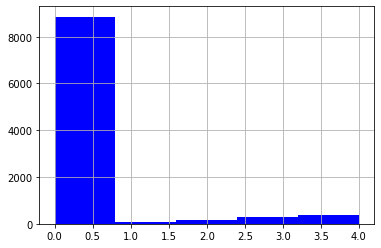

In [80]:
df_submission["prediction"].hist(bins=5,color='blue' )